In [1]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Подключим Keras и все необходимые нам модули

In [3]:
import keras
from keras import applications
from keras.applications import imagenet_utils
from keras import backend as K
import numpy as np
import tensorflow as tf

In [4]:
from keras.utils.vis_utils import model_to_dot

In [5]:
from scipy.misc import imresize

In [6]:
from imageio import imread, imwrite

In [8]:
sess = K.get_session()
sess.as_default()

In [9]:
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10) # set default size of plots

В модуле applications вы сможете найти большое количество предтренированных моделей. Загрузим уже знакомый нам VGG16, обученный на Imagenet

In [13]:
# build the VGG16 network
K.clear_session()
model = applications.VGG16(include_top=True,
                           weights='imagenet')

В Keras существуют удобные средства для визуализации моделей. 

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Так же мы можем вывести на экран граф модели:

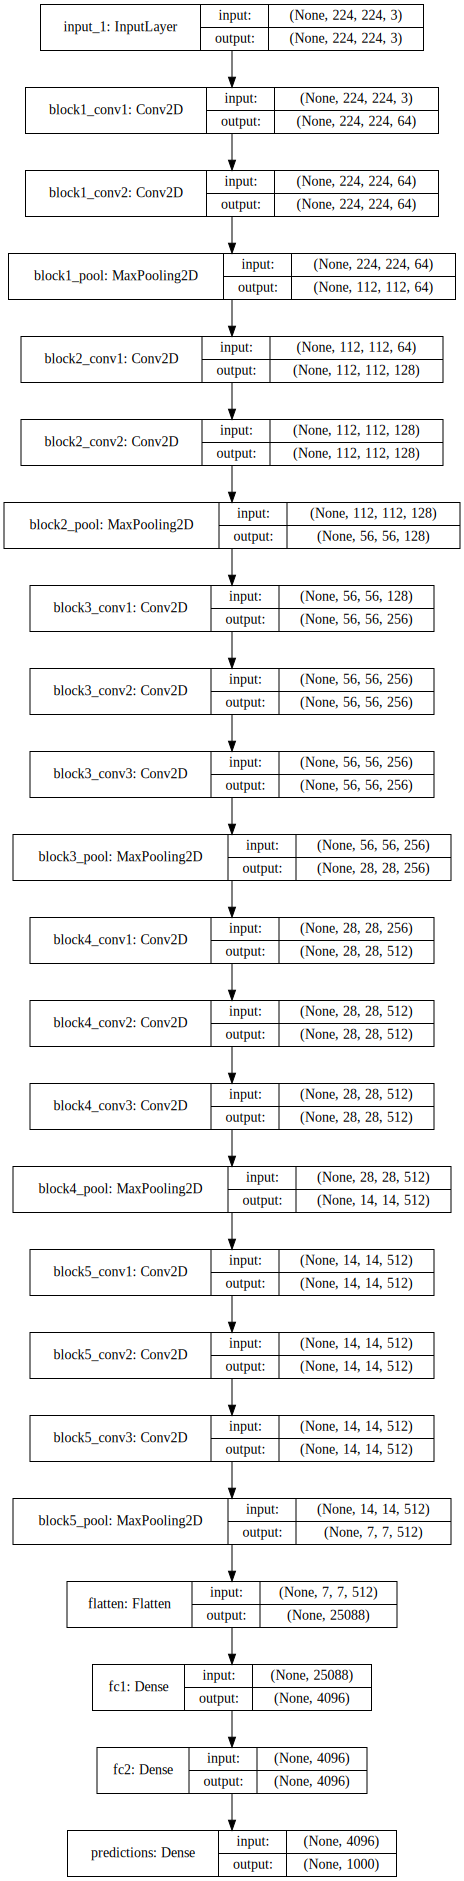

In [15]:
from IPython.display import SVG
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

Загрузим произвольную фотографию. Можно из http://image-net.org/, а можно и просто произвольную.

In [16]:
image = imread('image_1.jpg')

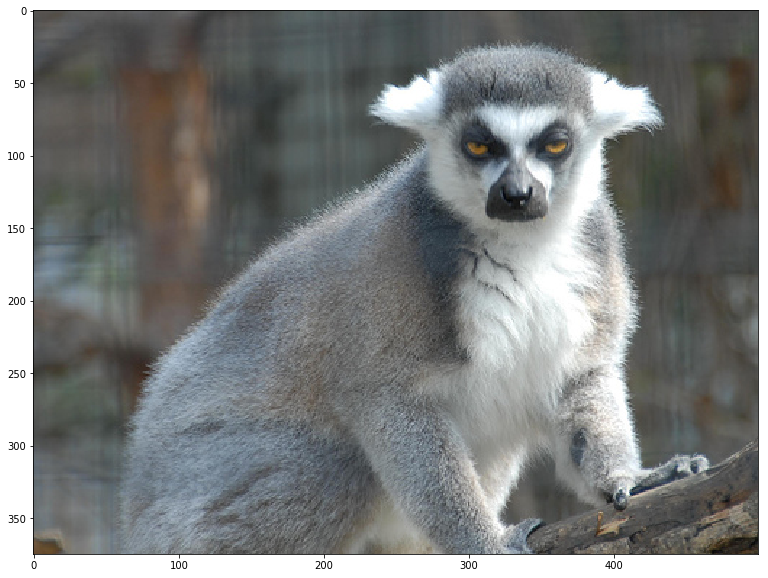

In [17]:
plt.imshow(image)

Обратите внимание, что изображения должнв иметь разрешение 224х224

In [19]:
resized_image = imresize(image, (224, 224))

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


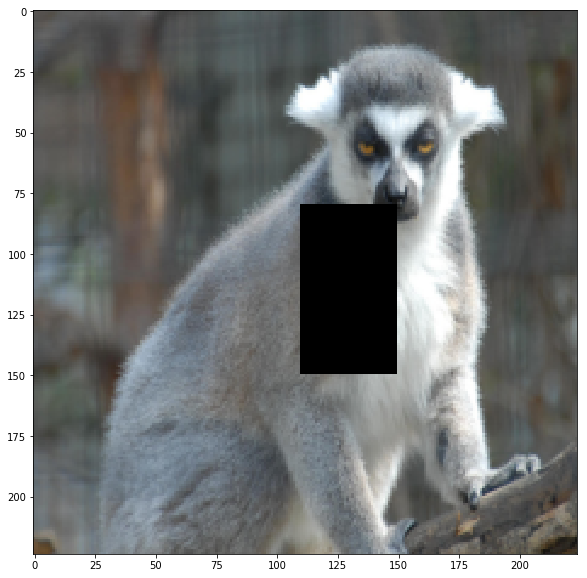

In [72]:
plt.imshow(resized_image)

In [71]:
resized_image[80:150, 110:150] = 0

Проверим может ли модель определить, к какому классу относится объект на изображении

In [73]:
y = model.predict(np.expand_dims(resized_image, 0))

In [74]:
np.argmax(y)

383

В Keras есть специальная функция, которая достаёт лейблы классов из Imagenet

In [75]:
imagenet_utils.decode_predictions(y)

[[('n02497673', 'Madagascar_cat', 0.7892411),
  ('n02483362', 'gibbon', 0.107858606),
  ('n02500267', 'indri', 0.024853323),
  ('n02138441', 'meerkat', 0.019314833),
  ('n02437616', 'llama', 0.013103379)]]

Теперь определим функцию, считающую градиент от выходов модели 

In [59]:
# Получаем тензор, отвечающий за вход модели
input_img = model.input

# Получаем тензор, отвечающий за выход
output = model.output
# s_output = K.softmax(model.output)

# Вызываем метод бэкенда, рассчитывающий градиент
grads = K.gradients(output, input_img)[0]

# Оборачиваем всё это в специальную абстракцию,
# которая скрывает вызов сессии TF
get_gradient = K.function([input_img], [grads])

Теперь мы можем рассчитать градиент

In [60]:
grad_val = get_gradient([np.expand_dims(resized_image, 0)])[0]

Как видим, shape градиента совпадает с shape изображения

In [61]:
grad_val.shape

(1, 224, 224, 3)

In [62]:
grad_val = np.squeeze(grad_val)

Для того, чтобы "посветить" значимые области найдём максимум поканально

In [63]:
mask = np.max(np.abs(grad_val), axis=-1)

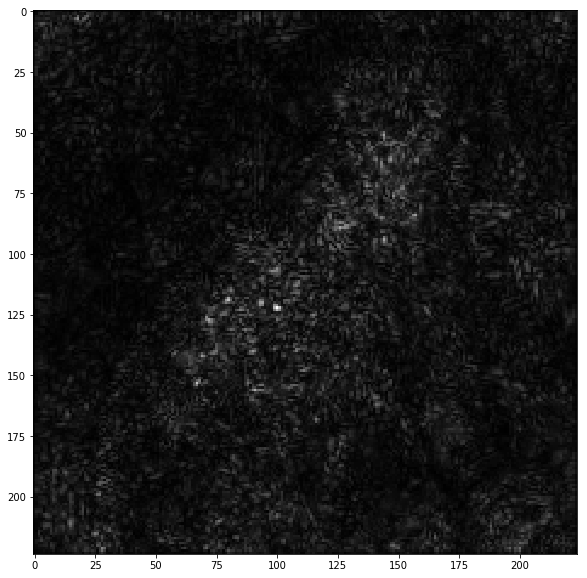

In [64]:
plt.imshow(mask, cmap='gray')

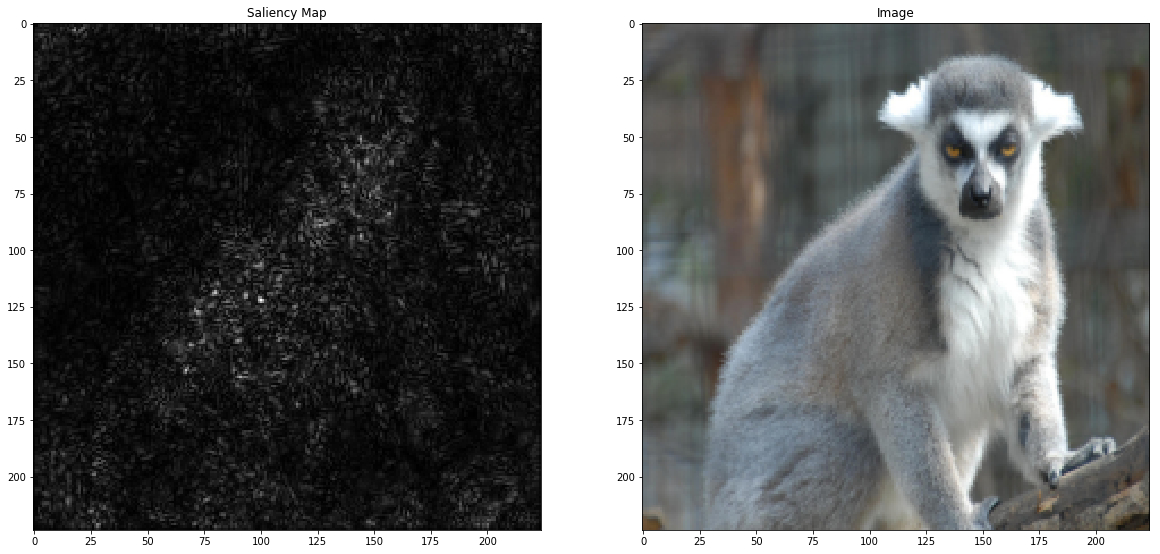

In [65]:
fig = plt.figure()
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(mask, cmap='gray')
a.set_title('Saliency Map')
a=fig.add_subplot(1,2,2)
imgplot = plt.imshow(resized_image)
a.set_title('Image')
plt.show()